# Phase 1 - Lane Line Detection

### Approach Steps:
- Read photo
- Apply Pre-processing Techniques
- Try getting HLS channels first to get rid of lightness noise
- Extract edges with Sobel from different informative views and stacking them together
- Try to apply perspective transform to convert to Bird's eye view
- Need to impelement a function to detect lane line using sliding window
- Why not improve the prvious function instead of performing blind search with each new frame, it should use info extracted from the previous frame
- Calculate radius of curvature and position from the center of the lane

next final outputs and complete the uncompleted functions pipeline() function and make final outputs you still need to unwarp the image and draw and fill the lane and make the code adaptive to videos

### Import Libraries:

In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

--------------------------------

### Implemented Functions:

In [2]:
def grayscale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

In [3]:
def gaussian(img, kernel_size):
    """Applies Guassian filter on the image"""
    blurry = cv2.GaussianBlur(img, (kernel_size,kernel_size), 0)
    return blurry

In [4]:
def abs_sobel_thresh(img, orients='x', sobel_kernel=3, thresh=(0,255)):
    """
    This function takes the image and applies sobel filter to it to
    take gradients of the image
    """
    gray = grayscale(img)
    
    if(orients == 'x'):
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if(orients == 'y'):
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        
    # rescale to 8 bits
    scaled_sobel = np.uint8((255*abs_sobel)/np.max(abs_sobel))
    
    # create a copy and apply threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

In [5]:
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    """
    A function to get the magnitude sobel and output a binary 8 bits image
    """
    gray = grayscale(img)
    
    # Getting Sobel
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # get gradient magnitude
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    
    # rescale to 8 bit
    scale_factor = np.max(grad_mag)/255
    
    grad_mag = (grad_mag/scale_factor).astype(np.uint8)
    
    # create a copy and apply threshold
    binary_output = np.zeros_like(grad_mag)
    binary_output[(grad_mag >= thresh[0]) & (grad_mag <= thresh[1])] = 1
    
    return binary_output

In [6]:
def dir_thresh(img, sobel_kernel=3, thresh=(0,np.pi/2)):
    """
    a function to get the direction sobel and output a binary 8 bits image
    """
    gray = grayscale(img)
    
    # Getting Sobel
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # get absolute value of gradient direction
    abs_grad_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # create a copy and apply threshold
    binary_output = np.zeros_like(abs_grad_dir)
    binary_output[(abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])] = 1
    
    return binary_output

In [7]:
def hls_select(img, thresh=(0,255)):
    """
    A function that converts the image from RGB to HLS and apply thresholdd
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    return binary_output

In [8]:
def warp_image(img):
    """""
    A function to transform the image to Bird's eye view to make it easy
    in radius of curvature and position calculations
    """""
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32([
        [800,510],
        [1150,700],
        [270,700],
        [510,510]
    ])
    
    dst = np.float32([
        [650,470],
        [640,700],
        [270,700],
        [270,510]
    ])
    
    # get perspective
    M = cv2.getPerspectiveTransform(src,dst)
    
    # get inverse perspective
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    # warp image
    warped_image = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    # unwar image
    unwarped_image = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    return warped_image, unwarped_image, M, Minv

In [9]:
def find_lane_pixels(warped_image, plot= False):
    
    #Try changing nwindows from 9 and see what is the difference
    
    # make a copy to work on
    binary_warped = warped_image.copy()
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//4)
    leftx_base = np.argmax(histogram[:midpoint])
    
    # we shouldn't take the range from midpoint to end because it will detect
    # the lane line in the end of the photo not the end of the same lane line
    rightx_base = np.argmax(histogram[midpoint:midpoint + 500]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if plot == True:
        plt.figure(figsize=(10,10))
        fig = plt.figure()

        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, plot=False)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [255, 0, 0]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return left_fit, right_fit, out_img

In [10]:
def fit_continuous(left_fit, right_fit, warped_image, plot = True):
    
    binary_warped = warped_image.copy
    
    #Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_new =[]
    else:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    
    
    if len(rightx) == 0:
        right_fit_new =[]
    else:
        right_fit_new = np.polyfit(righty, rightx, 2)
        
    if plot == True:
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
   
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit_new, right_fit_new, result

In [11]:
def lane_detection(img_file, apply_blur=False):
    """""
    A pipeline function to get the output with one function,
    It is combining some lane detection the steps in one function
    """""
    
    # read image
    image = cv2.imread(img_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # if blur argument is true define a kernel size of 5x5 and apply
    # gaussian blur
    if(apply_blur == True):
        kernel_size = 5
        image = gaussian(image, kernel_size)
        
    
    # applying gradient and color thresholding then combining
    sobelx_bin = abs_sobel_thresh(image, orients='x', sobel_kernel=3, thresh=(22,100))
    mag_bin = mag_thresh(image, sobel_kernel=3, thresh=(40, 100))
    dir_bin = dir_thresh(image, sobel_kernel=3, thresh=(0.7, 1.3))
    
    S_channel_bin = hls_select(image, thresh=(90,255))
    
    # Combine different binary thresholds
    combined_bin1 = np.zeros_like(sobelx_bin)
    combined_bin1[(sobelx_bin == 1) | (S_channel_bin == 1)] = 1
    
    combined_bin2 = np.zeros_like(sobelx_bin)
    combined_bin2[(sobelx_bin == 1) | (S_channel_bin == 1) | (mag_bin == 1)] = 1
    
    # Apply perspective transform
    # return warped_image, unwarped_image, M, Minv of warp_image(img) function
    # we will need the Minv later
    # combined_bin1 is the best to work with
    
    warped_image, _,_,_ = warp_image(combined_bin1)
    
    return image, sobelx_bin, S_channel_bin, combined_bin1, combined_bin2, warped_image

In [27]:
#Calculate Curvature

def curvature(left_fit, right_fit, binary_warped, print_data = True):
    """""""""
    This function calculates the radius of curvature of the road and the position
    from the center of the lane
    """""""""
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #Define left and right lanes in pixels
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #Identify new coefficients in metres
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #Calculation of center
    #left_lane and right lane bottom in pixels
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    # Lane center as mid of left and right lane bottom
                            
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = 640
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    
    if print_data == True:
    #Now our radius of curvature is in meters
        #print(left_curverad, 'm ', right_curverad, 'm ', center, 'm ')

        print("Left Curvature: ", left_curverad, 'm \t', "Right Curvature: ", right_curverad, 'm ')
        print("Position from center: ", center, 'm ')

    return left_curverad, right_curverad, center

In [13]:
def take_filename():
    # simple function to take file name as input from user
    file_name = input("Enter file path and Name (eg. /.../...): ")
    return file_name


def pipeline():
    """""""""
    This will be the final collected function to apply all processing
    
    It should take:
    boolean: blur
    int: blur kernel size
    boolean: video or not
    
    To be completed
    and it will take input string from the user with file name to work on
    if video it should extract frames to work on and then recollect them again
    """""""""
    #image = take_filename
    image = 'test_images/test3.jpg'
    
    global counter
    global last_left 
    global last_right
    global left_fit
    global right_fit
    
    orig, sobelx_bin, S_channel_bin, combined_bin1, combined_bin2, warped_image = lane_detection(image, apply_blur=False)
    
    if counter ==0:
        left_fit, right_fit, out_img = fit_polynomial(warped_image)
    else:
        left_fit, right_fit, out_img  = fit_continuous(left_fit, right_fit, warped_image, plot = False)
        

    # Get radius of curvature and position
    # return left_curverad, right_curverad, center
    left_curverad, right_curverad, center = curvature(left_fit, right_fit, out_img)
        

    #plt.imshow(out_img)
    
    return warped_image, out_img, left_curverad, right_curverad, center

--------------------------------------

### Step by Step Cells

In [14]:
test = 1 # flag to test

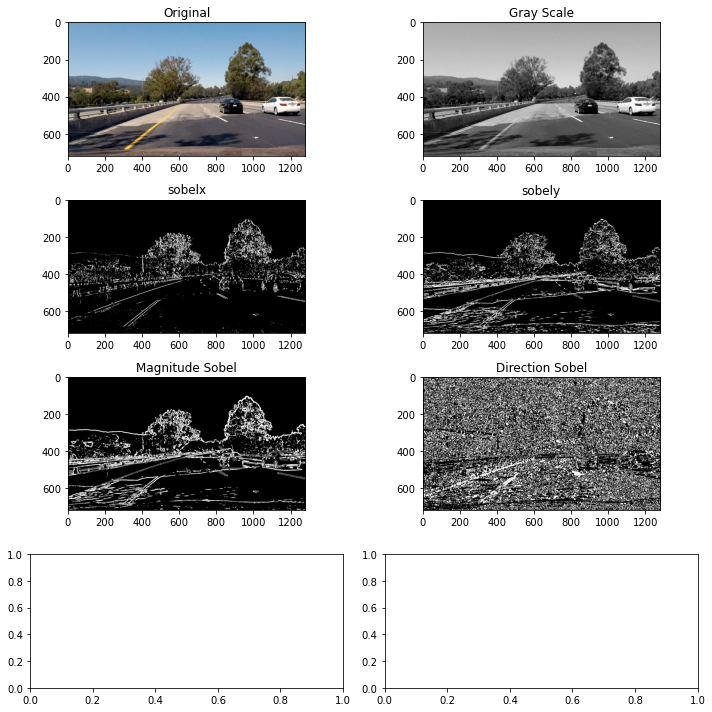

In [15]:
# Test Cell

file = os.path.join("test_images/", "test4.jpg")
image = cv2.imread(file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = grayscale(image)

#playing with sobel
grad_binary_x = abs_sobel_thresh(image, orients='x', thresh=(20,100))
grad_binary_y = abs_sobel_thresh(image, orients='y', thresh=(20,100))

# sobel magnitude and direction thresholds
magthreshold = mag_thresh(image, sobel_kernel=9, thresh=(30, 100))
dirthreshold = dir_thresh(image, sobel_kernel=15, thresh=(0.7, 1.3))


if (test == 1):
    f, ax = plt.subplots(4,2, figsize=(10,10))
    
    ax[0,0].set_title('Original')
    ax[0,0].imshow(image)
    
    ax[0,1].set_title('Gray Scale')
    ax[0,1].imshow(gray, cmap = 'gray')
    
    ax[1,0].set_title('sobelx')
    ax[1,0].imshow(grad_binary_x, cmap = 'gray')
    
    ax[1,1].set_title('sobely')
    ax[1,1].imshow(grad_binary_y, cmap = 'gray')
    
    ax[2,0].set_title('Magnitude Sobel')
    ax[2,0].imshow(magthreshold, cmap = 'gray')
    
    ax[2,1].set_title('Direction Sobel')
    ax[2,1].imshow(dirthreshold, cmap = 'gray')
    
    f.tight_layout()
    plt.show()

In [16]:
file = os.path.join("test_images/", "test4.jpg")
image = cv2.imread(file)

B = image[:,:,0]
G = image[:,:,1]
R = image[:,:,2]

hls_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
H = hls_image[:,:,0]
L = hls_image[:,:,1]
S = hls_image[:,:,2]

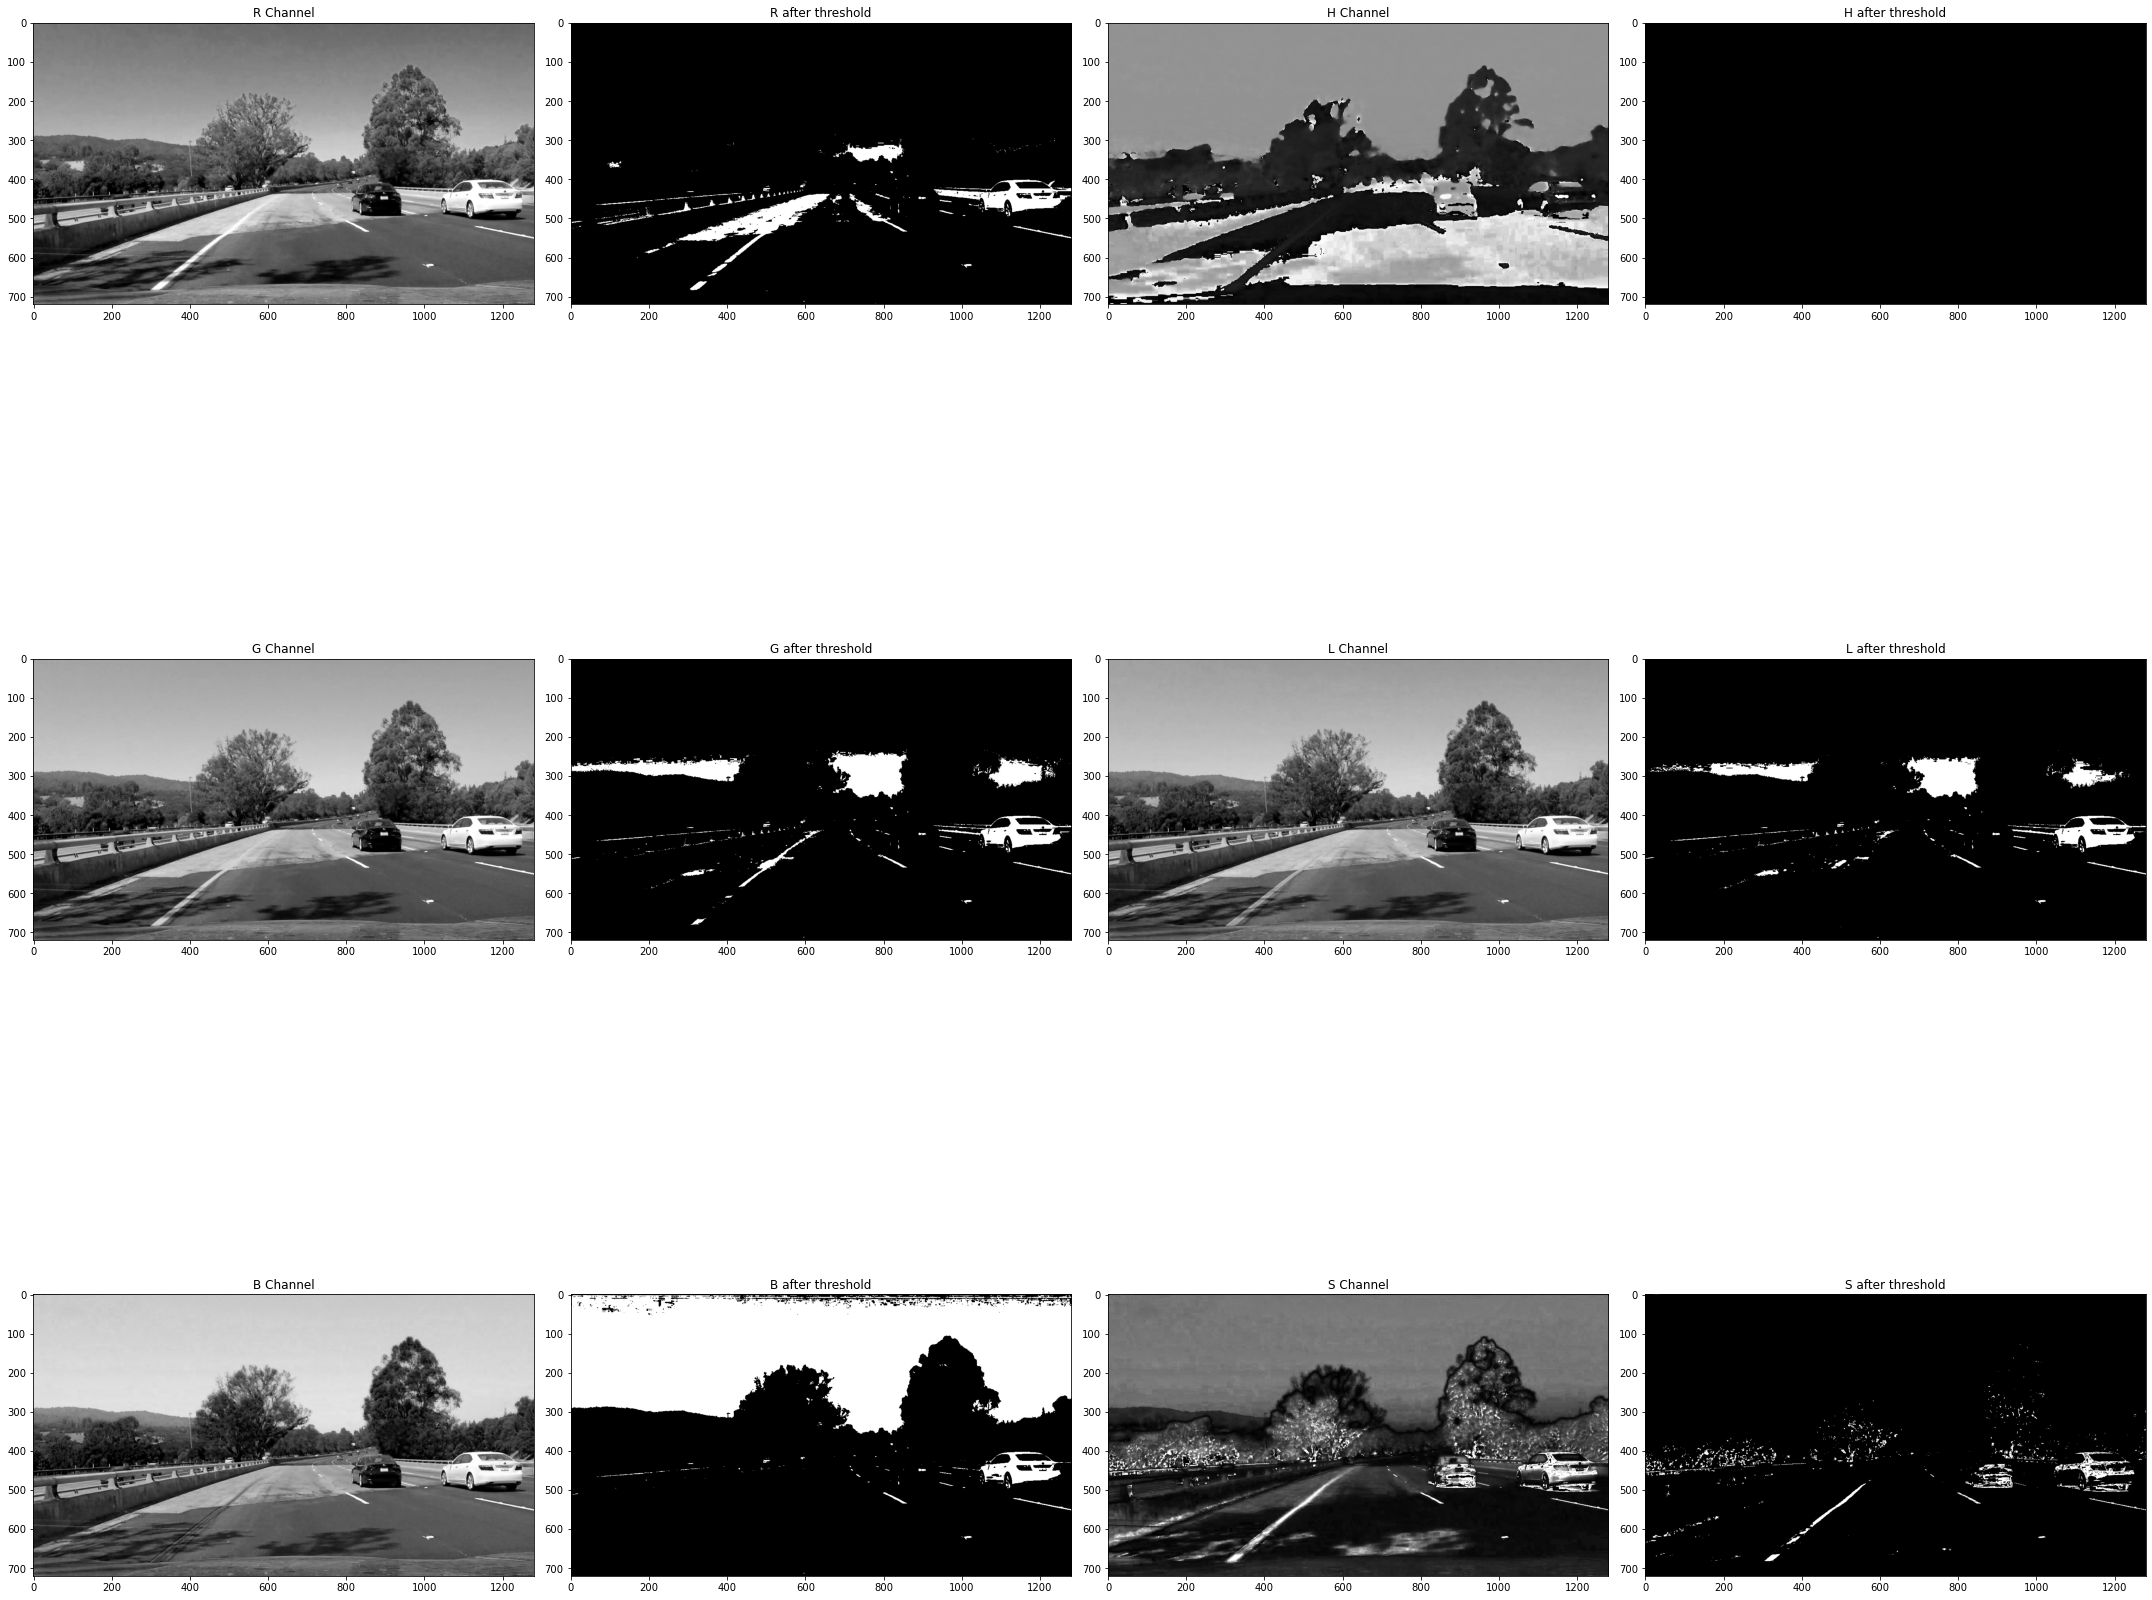

In [25]:
# Testing different channels and thresholding to get lane lines

# RGB
threshR = (200, 255)
binaryR = np.zeros_like(R)
binaryR[(R > threshR[0]) & (R <= threshR[1])] = 1

threshG = (200, 255)
binaryG = np.zeros_like(G)
binaryG[(G > threshG[0]) & (G <= threshG[1])] = 1

threshB = (200, 255)
binaryB = np.zeros_like(B)
binaryB[(B > threshB[0]) & (B <= threshB[1])] = 1


#---------------------------------------------
# HLS
threshH = (200, 255)
binaryH = np.zeros_like(H)
binaryH[(H > threshH[0]) & (H <= threshH[1])] = 1

threshL = (200, 255)
binaryL = np.zeros_like(L)
binaryL[(L > threshL[0]) & (L <= threshL[1])] = 1

threshS = (200, 255)
binaryS = np.zeros_like(S)
binaryS[(S > threshS[0]) & (S <= threshS[1])] = 1

if (test == 1):
    f, ax = plt.subplots(3,4, figsize=(30,30))
    
    ax[0,0].set_title('R Channel')
    ax[0,0].imshow(R, cmap = 'gray')
    
    ax[0,1].set_title('R after threshold')
    ax[0,1].imshow(binaryR, cmap = 'gray')
    
    ax[1,0].set_title('G Channel')
    ax[1,0].imshow(G, cmap = 'gray')
    
    ax[1,1].set_title('G after threshold')
    ax[1,1].imshow(binaryG, cmap = 'gray')
    
    ax[2,0].set_title('B Channel')
    ax[2,0].imshow(B, cmap = 'gray')
    
    ax[2,1].set_title('B after threshold')
    ax[2,1].imshow(binaryB, cmap = 'gray')
    
    #--------------------------------------------
    ax[0,2].set_title('H Channel')
    ax[0,2].imshow(H, cmap = 'gray')
    
    ax[0,3].set_title('H after threshold')
    ax[0,3].imshow(binaryH, cmap = 'gray')
    
    ax[1,2].set_title('L Channel')
    ax[1,2].imshow(L, cmap = 'gray')
    
    ax[1,3].set_title('L after threshold')
    ax[1,3].imshow(binaryL, cmap = 'gray')
    
    ax[2,2].set_title('S Channel')
    ax[2,2].imshow(S, cmap = 'gray')
    
    ax[2,3].set_title('S after threshold')
    ax[2,3].imshow(binaryS, cmap = 'gray')
    
    f.tight_layout()
    plt.show()

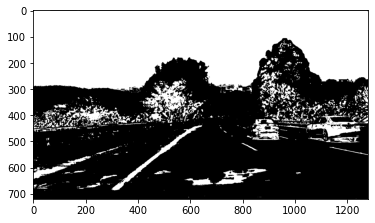

In [18]:
file = os.path.join("test_images/", "test4.jpg")
image = cv2.imread(file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

hls_binary = hls_select(image, thresh=(90,255))
plt.imshow(hls_binary, cmap='gray')

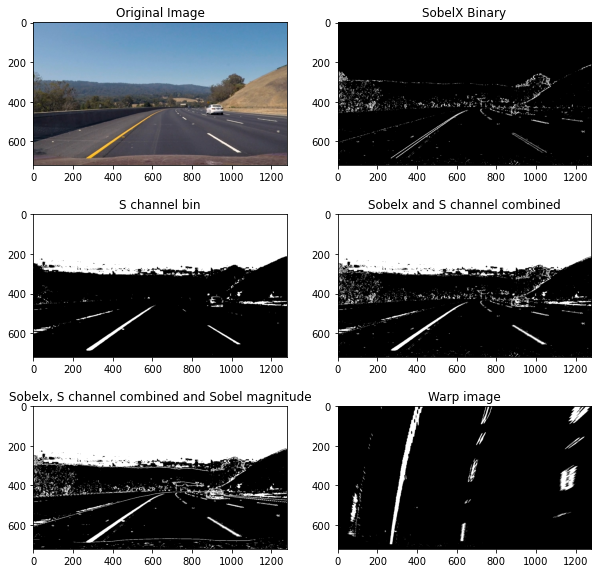

In [19]:
# Test lane_detection() function
# return image, sobelx_bin, S_channel_bin, combined_bin1, combined_bin2, warped_image

# read image
image= 'test_images/test3.jpg'
orig, sobelx_bin, S_channel_bin, combined_bin1, combined_bin2, warped_image = lane_detection(image, apply_blur=False)

if(test==1):
    f, ax = plt.subplots(3,2, figsize=(10,10))
    
    ax[0,0].set_title('Original Image')
    ax[0,0].imshow(orig)
    
    ax[0,1].set_title('SobelX Binary')
    ax[0,1].imshow(sobelx_bin, cmap = 'gray')
    
    ax[1,0].set_title('S channel bin')
    ax[1,0].imshow(S_channel_bin, cmap = 'gray')
    
    ax[1,1].set_title('Sobelx and S channel combined')
    ax[1,1].imshow(combined_bin1, cmap = 'gray')
    
    ax[2,0].set_title('Sobelx, S channel combined and Sobel magnitude')
    ax[2,0].imshow(combined_bin2, cmap = 'gray')
    
    ax[2,1].set_title('Warp image')
    ax[2,1].imshow(warped_image, cmap = 'gray')

Left Curvature:  1291.084353786899 m 	 Right Curvature:  1346.786871890622 m 
Position from center:  -0.2988581986571257 m 


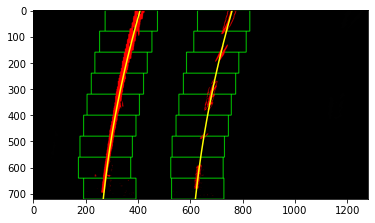

In [28]:
counter = 0
warped_image, out_img, left_curverad, right_curverad, center = pipeline()

plt.imshow(out_img)
#plt.imshow(warped_image, cmap='gray')

<Figure size 720x720 with 0 Axes>

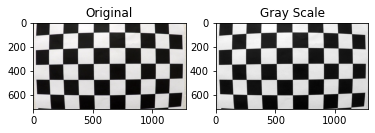

<Figure size 720x720 with 0 Axes>

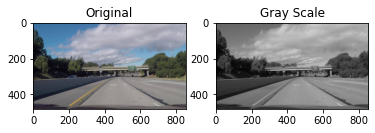

<Figure size 720x720 with 0 Axes>

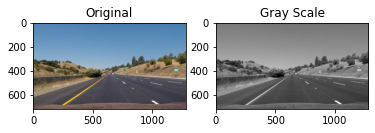

<Figure size 720x720 with 0 Axes>

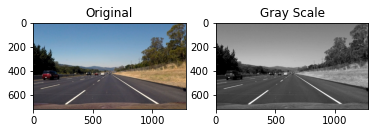

<Figure size 720x720 with 0 Axes>

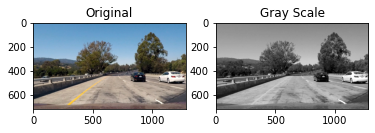

<Figure size 720x720 with 0 Axes>

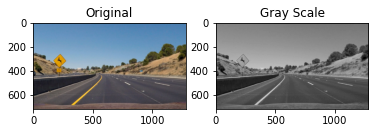

<Figure size 720x720 with 0 Axes>

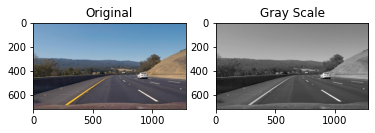

<Figure size 720x720 with 0 Axes>

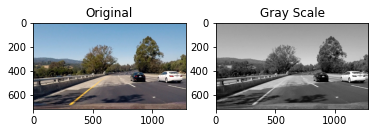

<Figure size 720x720 with 0 Axes>

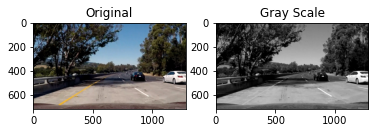

<Figure size 720x720 with 0 Axes>

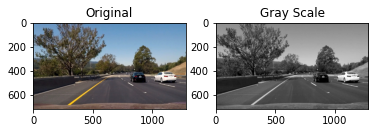

In [35]:
# Cell to read test photos
new_path = os.path.join("test_images/", "*jpg")

#images = []

for infile in glob.glob(new_path):
    image = infile
    orig_image = cv2.imread(image)
    rgb = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    #images.append(rgb)
    #Plots 
    plt.figure(figsize=(10,10))
    fig = plt.figure()
    a=fig.add_subplot(2,2,1)
    plt.imshow(rgb)
    a.set_title('Original')
    
    a=fig.add_subplot(2,2,2)
    plt.imshow(gray, cmap = 'gray')
    a.set_title('Gray Scale')